In [1]:
# Use energy consumtion data to classify weekdays vs. weekends (or vacation days) 

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import where
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

#### Import, clean and format data

Your usage data might come in different format and units. To make sure we will be able to generate some useful images, we need to inspect and if necessary transform the data. 

In [3]:
# Import the raw data
# I am using an energy profile that I downloaded from openMeter, a free data platform
raw_data = pd.read_csv("dab2f457.csv", delimiter=';')

In [4]:
# Convert the values (replace ',' with '.' and convert to floats)
raw_data['Messwert'] = raw_data['Messwert'].str.replace(',', '.').astype(float)

In [5]:
# inspect the data
print(raw_data)

             Zeitstempel  Messwert
0       31.12.2006 23:00    4.0200
1       01.01.2007 00:00    3.9850
2       01.01.2007 01:00    4.0650
3       01.01.2007 02:00    4.0875
4       01.01.2007 03:00    4.1200
...                  ...       ...
266343  10.12.2023 21:00    1.1725
266344  10.12.2023 21:15    1.1550
266345  10.12.2023 21:30    1.1725
266346  10.12.2023 21:45    1.1925
266347  10.12.2023 22:00    4.8075

[266348 rows x 2 columns]


We want the column with the timestamps to be the index - formatted as pandas datetime. 

In [6]:
# Instead of 'Zeitstempel', add your column name
raw_data = raw_data.set_index("Zeitstempel")

In [7]:
# Renaming index name
raw_data.rename_axis('index', inplace=True)

In [8]:
# We are using the pandas datetime format
raw_data.index = pd.to_datetime(raw_data.index)

C:\Users\Anka\AppData\Local\Temp\ipykernel_948\3400269385.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  raw_data.index = pd.to_datetime(raw_data.index)


In [9]:
# If necessary, rename the column. Instead of 'Messwert' , add your present column names.
raw_data.rename(columns={'Messwert': 'value_measured'}, inplace=True)

Note: In order to interpret your data later, make sure to note the units of your measurements.

In [10]:
# Inspect the data again
print(raw_data)

                     value_measured
index                              
2006-12-31 23:00:00          4.0200
2007-01-01 00:00:00          3.9850
2007-01-01 01:00:00          4.0650
2007-01-01 02:00:00          4.0875
2007-01-01 03:00:00          4.1200
...                             ...
2023-12-10 21:00:00          1.1725
2023-12-10 21:15:00          1.1550
2023-12-10 21:30:00          1.1725
2023-12-10 21:45:00          1.1925
2023-12-10 22:00:00          4.8075

[266348 rows x 1 columns]


Note: In order to interpret your data later, make sure to note the units of your measurements. My meter provided kWh per 15 minutes. 

<Axes: xlabel='index'>

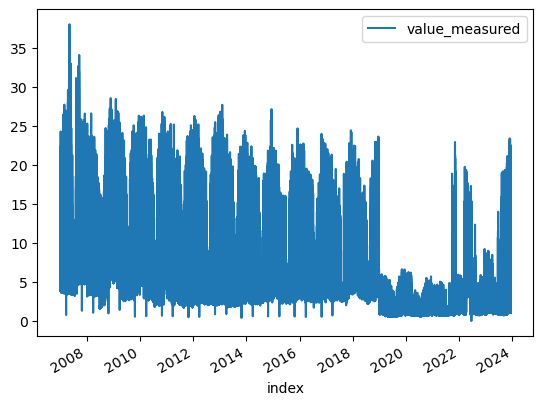

In [11]:
raw_data.plot()

<Axes: xlabel='index'>

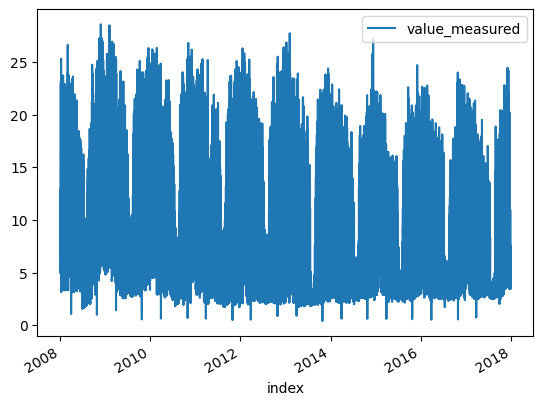

In [12]:
# Plot only data from a certain range
start_date = '2008-01-01'
end_date = '2018-01-01'

# Filter data within the date range
raw_data_B = raw_data[start_date:end_date]

raw_data_B.plot()

#### Define training data

For supervised learning, we need to provide some training data with labels. In our case, we need to provide some data that we already defined as schooldays or vacation days. I will choose some days from winter and some from summer.

##### label some data for training

<Axes: xlabel='index'>

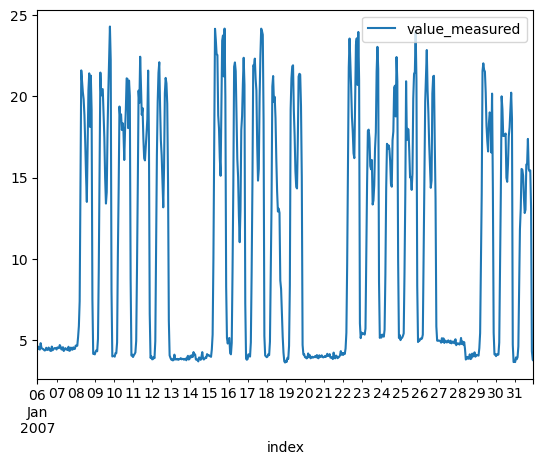

In [13]:
# Plot only data from a certain range
start_date = '2007-01-06'
end_date = '2007-01-31'

# Filter data within the date range
train_pre_1 = raw_data[start_date:end_date]

train_pre_1.plot()

In [14]:
# Manually specified numbers
label_1 = [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]

In [15]:
# confirm that you specified the correct number of days (the same number as in train_pre_1), if "True" is returned, the correct number of labels is defined
len((train_pre_1)) / 24 == len(label_1)

True

In [16]:
# Add more training data from summer (in case there is seasonal variation)

<Axes: xlabel='index'>

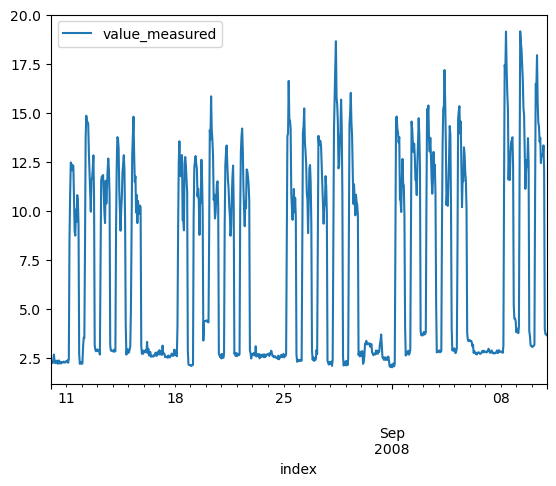

In [17]:
# Plot only data from a certain range
start_date = '2008-08-10'
end_date = '2008-09-10'

# Filter data within the date range
train_pre_2 = raw_data[start_date:end_date]

train_pre_2.plot()

In [18]:
# Manually specified numbers
label_2 = [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]

In [19]:
# confirm that you specified the correct number of days (the same number as in train_pre_1), if "True" is returned, the correct number of labels is defined
len((train_pre_2)) / 24 == len(label_2)

True

combine the dfs for training

<Axes: xlabel='index'>

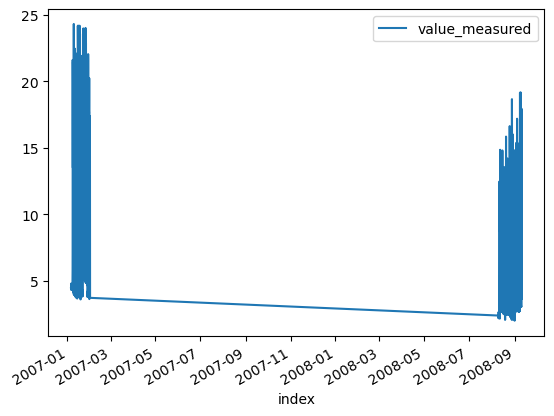

In [20]:
train_pre = pd.concat([train_pre_1, train_pre_2], ignore_index=False)
train_pre.plot()

In [21]:
train_pre

,value_measured
index,
2007-01-06 00:00:00,4.4450
2007-01-06 01:00:00,4.5900
2007-01-06 02:00:00,4.4600
2007-01-06 03:00:00,4.4075
2007-01-06 04:00:00,4.8025
...,...
2008-09-10 19:00:00,12.0700
2008-09-10 20:00:00,3.9700
2008-09-10 21:00:00,3.7075


In [22]:
# We will segment the training data into single days and store each day in a separate df in a dictionary
# Assuming train_pre is your original DataFrame
ind_train_dfs = {}

# Calculate the minimum time difference in the DataFrame between consecutive timestamps
group_time_diff = train_pre.index.to_series().diff().min()

# Define the number of rows per DataFrame (in case we would have more more then 24 measurements per day, we can adjust this)
rows_per_df = 24  # Adjust this value as needed

# Iterate through the datetime index of the DataFrame
for start_time in train_pre.index:
    # Check if the current start_time is 0:00 am
    if start_time.hour == 0 and start_time.minute == 0:
        # Calculate the end time for the slice
        end_time = start_time + pd.Timedelta(minutes=(rows_per_df - 1) * group_time_diff.total_seconds() / 60)
        ind_train_df = train_pre.loc[start_time:end_time].copy()  # Make a copy to avoid modifying the original DataFrame

        # Get the weekday at 12 noon
        weekday_at_noon = (start_time + pd.Timedelta(hours=7)).weekday()

        # Store the individual DataFrame in the dictionary with the weekday and start_time as part of the key
        ind_train_dfs[f"{start_time}"] = ind_train_df
        # ind_train_dfs[f"{weekday_at_noon}_{start_time}"] = ind_train_df
        # ind_train_dfs[f"{weekday_at_noon}"] = ind_train_df

In [23]:
# Iterate through the dictionary keys and DataFrames and check if all dfs contain 24 rows
keys_to_remove = [key for key, df in ind_train_dfs.items() if len(df) < 24]

# Remove the DataFrames with fewer than 24 rows
for key in keys_to_remove:
    del ind_train_dfs[key]

In [24]:
# Check that all DataFrames have the same shape and columns
shapes = [df.shape for df in ind_train_dfs.values()]
if not all(shape == shapes[0] for shape in shapes):
    raise ValueError("All DataFrames must have the same shape.")

In [25]:
columns = [df.columns.tolist() for df in ind_train_dfs.values()]
if not all(cols == columns[0] for cols in columns):
    raise ValueError("All DataFrames must have the same columns.")

We now need to convert the data into the proper format - 3D NumPy arrays:

In [26]:
# Convert each DataFrame to a 2D NumPy array and ensure it has the shape (1, number_of_rows)
X_train_interm = [df.to_numpy().T for df in ind_train_dfs.values()]

# Stack these 2D arrays into a 3D NumPy array with shape (number_of_dfs, 1, number_of_rows)
X_train = np.stack(X_train_interm, axis=0)

# Inspect the shape of the dictionary
print(X_train.shape)

# Optional: Access the original DataFrame keys if needed
df_train_keys = list(ind_train_dfs.keys())
print(df_train_keys)

(58, 1, 24)
['2007-01-06 00:00:00', '2007-01-07 00:00:00', '2007-01-08 00:00:00', '2007-01-09 00:00:00', '2007-01-10 00:00:00', '2007-01-11 00:00:00', '2007-01-12 00:00:00', '2007-01-13 00:00:00', '2007-01-14 00:00:00', '2007-01-15 00:00:00', '2007-01-16 00:00:00', '2007-01-17 00:00:00', '2007-01-18 00:00:00', '2007-01-19 00:00:00', '2007-01-20 00:00:00', '2007-01-21 00:00:00', '2007-01-22 00:00:00', '2007-01-23 00:00:00', '2007-01-24 00:00:00', '2007-01-25 00:00:00', '2007-01-26 00:00:00', '2007-01-27 00:00:00', '2007-01-28 00:00:00', '2007-01-29 00:00:00', '2007-01-30 00:00:00', '2007-01-31 00:00:00', '2008-08-10 00:00:00', '2008-08-11 00:00:00', '2008-08-12 00:00:00', '2008-08-13 00:00:00', '2008-08-14 00:00:00', '2008-08-15 00:00:00', '2008-08-16 00:00:00', '2008-08-17 00:00:00', '2008-08-18 00:00:00', '2008-08-19 00:00:00', '2008-08-20 00:00:00', '2008-08-21 00:00:00', '2008-08-22 00:00:00', '2008-08-23 00:00:00', '2008-08-24 00:00:00', '2008-08-25 00:00:00', '2008-08-26 00:00:00'

In [27]:
# y_train contains the labels we had specified earlier
y_train = np.array(label_1 + label_2, dtype='<U1')
y_train

array(['0', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1',
       '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1',
       '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1',
       '0', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1',
       '1', '0', '0', '1', '1', '1'], dtype='<U1')

In [28]:
y_train.shape

(58,)

#### Define test data

<Axes: xlabel='index'>

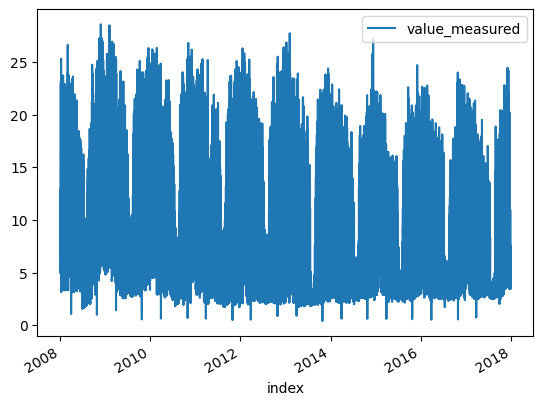

In [29]:
# You might want to narrow down the test period
# Plot only data from a certain range
start_date = '2008-01-01'
end_date = '2018-01-01'

# Filter data within the date range
test_pre = raw_data_B[start_date:end_date]

test_pre.plot()

In [30]:
# As for the training data, we need to segment the test data
# Assuming summer_df is your original DataFrame
ind_test_dfs = {}

# Calculate the minimum time difference in the DataFrame
group_time_diff = test_pre.index.to_series().diff().min()

# Define the number of rows per DataFrame
rows_per_df = 24  # Adjust this value as needed

# Iterate through the datetime index of the DataFrame
for start_time in test_pre.index:
    # Check if the current start_time is 0:00 am
    if start_time.hour == 0 and start_time.minute == 0:
        # Calculate the end time for the slice
        end_time = start_time + pd.Timedelta(minutes=(rows_per_df - 1) * group_time_diff.total_seconds() / 60)
        ind_test_df = test_pre.loc[start_time:end_time].copy()  # Make a copy to avoid modifying the original DataFrame

        # Get the weekday at 12 noon
        weekday_at_noon = (start_time + pd.Timedelta(hours=7)).weekday()

        # Store the individual DataFrame in the dictionary with the weekday and start_time as part of the key
        ind_test_dfs[f"{start_time}"] = ind_test_df

In [31]:
# Iterate through the dictionary keys and DataFrames
keys_to_remove = [key for key, df in ind_test_dfs.items() if len(df) < 24]

# Remove the DataFrames with fewer than 24 rows
for key in keys_to_remove:
    del ind_test_dfs[key]

In [32]:
# Check that all DataFrames have the same shape and columns
shapes = [df.shape for df in ind_test_dfs.values()]
if not all(shape == shapes[0] for shape in shapes):
    raise ValueError("All DataFrames must have the same shape.")

In [33]:
columns = [df.columns.tolist() for df in ind_test_dfs.values()]
if not all(cols == columns[0] for cols in columns):
    raise ValueError("All DataFrames must have the same columns.")

In [34]:
# Convert the test data to NumPy array
# Convert each DataFrame to a 2D NumPy array and ensure it has the shape (1, number_of_rows)
X_test_interm = [df.to_numpy().T for df in ind_test_dfs.values()]

# Stack these 2D arrays into a 3D NumPy array with shape (number_of_dfs, 1, number_of_rows)
X_test = np.stack(X_test_interm, axis=0)

print(X_test.shape)  

# Optional: Access the original DataFrame keys if needed
df_test_keys = list(ind_test_dfs.keys())
print(df_test_keys)

(3633, 1, 24)
['2008-01-01 00:00:00', '2008-01-02 00:00:00', '2008-01-03 00:00:00', '2008-01-04 00:00:00', '2008-01-05 00:00:00', '2008-01-06 00:00:00', '2008-01-07 00:00:00', '2008-01-08 00:00:00', '2008-01-09 00:00:00', '2008-01-10 00:00:00', '2008-01-11 00:00:00', '2008-01-12 00:00:00', '2008-01-13 00:00:00', '2008-01-14 00:00:00', '2008-01-15 00:00:00', '2008-01-16 00:00:00', '2008-01-17 00:00:00', '2008-01-18 00:00:00', '2008-01-19 00:00:00', '2008-01-20 00:00:00', '2008-01-21 00:00:00', '2008-01-22 00:00:00', '2008-01-23 00:00:00', '2008-01-24 00:00:00', '2008-01-25 00:00:00', '2008-01-26 00:00:00', '2008-01-27 00:00:00', '2008-01-28 00:00:00', '2008-01-29 00:00:00', '2008-01-30 00:00:00', '2008-01-31 00:00:00', '2008-02-01 00:00:00', '2008-02-02 00:00:00', '2008-02-03 00:00:00', '2008-02-04 00:00:00', '2008-02-05 00:00:00', '2008-02-06 00:00:00', '2008-02-07 00:00:00', '2008-02-08 00:00:00', '2008-02-09 00:00:00', '2008-02-10 00:00:00', '2008-02-11 00:00:00', '2008-02-12 00:00:0

In [35]:
y_test = np.array(df_train_keys, dtype='<U1')
# y_train

#### Inspect test- and training data

In [36]:
# before fitting the algorithm, we check the shapes of all the arrays we defined

In [37]:
y_train.shape

(58,)

In [38]:
y_test.shape

(58,)

In [39]:
X_test.shape

(3633, 1, 24)

In [40]:
X_test.shape

(3633, 1, 24)

In [41]:
# 3-NN with simple dynamic time warping distance (requires numba)
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3)

In [42]:
# 3-nearest neighbour classifier with Euclidean distance (on flattened time series)
# (requires scipy)
# from sktime.dists_kernels import FlatDist, ScipyDist

# eucl_dist = FlatDist(ScipyDist())
# clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)

In [43]:
# fit/train the classifier
clf.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier(n_neighbors=3)

In [44]:
# The classifier is now fitted
clf.is_fitted

True

In [45]:
# Predict labels on new data
y_pred = clf.predict(X_test)
y_pred

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U1')

#### Plot results

In [46]:
# We are creating a dataframe with the df_test_keys and values in y_pred as results in the column "prediction"
# Create an empty DataFrame with df_test_keys as the index
result_df = pd.DataFrame(index=df_test_keys)

# Adding y_pred as a column to test_df
result_df['prediction'] = y_pred

# Display the resulting DataFrame
print(result_df)

                    prediction
2008-01-01 00:00:00          0
2008-01-02 00:00:00          0
2008-01-03 00:00:00          0
2008-01-04 00:00:00          1
2008-01-05 00:00:00          0
...                        ...
2017-12-28 00:00:00          0
2017-12-29 00:00:00          0
2017-12-30 00:00:00          0
2017-12-31 00:00:00          0
2018-01-01 00:00:00          0

[3633 rows x 1 columns]


In [47]:
# Our original data had hourly measurements, so we need to fill up the result_df
# Convert the index to DatetimeIndex
result_df.index = pd.to_datetime(result_df.index)

# Resample to hourly frequency and forward fill the data
result_df = result_df.resample('H').ffill()

# Display the updated test_df
print(result_df)

                    prediction
2008-01-01 00:00:00          0
2008-01-01 01:00:00          0
2008-01-01 02:00:00          0
2008-01-01 03:00:00          0
2008-01-01 04:00:00          0
...                        ...
2017-12-31 20:00:00          0
2017-12-31 21:00:00          0
2017-12-31 22:00:00          0
2017-12-31 23:00:00          0
2018-01-01 00:00:00          0

[87673 rows x 1 columns]


For plotting the data, we are again using the df test_pre that we had initially used to create the array with the training data.

In [48]:
# result_df contains the results of the prediction, test_pre has the original data. We merge them on their indices.
merged_result = pd.merge(test_pre, result_df, left_index=True, right_index=True, how='left')

In [49]:
merged_result

,value_measured,prediction
index,,
2008-01-01 00:00:00,5.0500,0
2008-01-01 01:00:00,5.3525,0
2008-01-01 02:00:00,5.2350,0
2008-01-01 03:00:00,5.3100,0
2008-01-01 04:00:00,6.1325,0
...,...,...
2018-01-01 19:00:00,5.0750,NaN
2018-01-01 20:00:00,5.0175,NaN
2018-01-01 21:00:00,3.9825,NaN


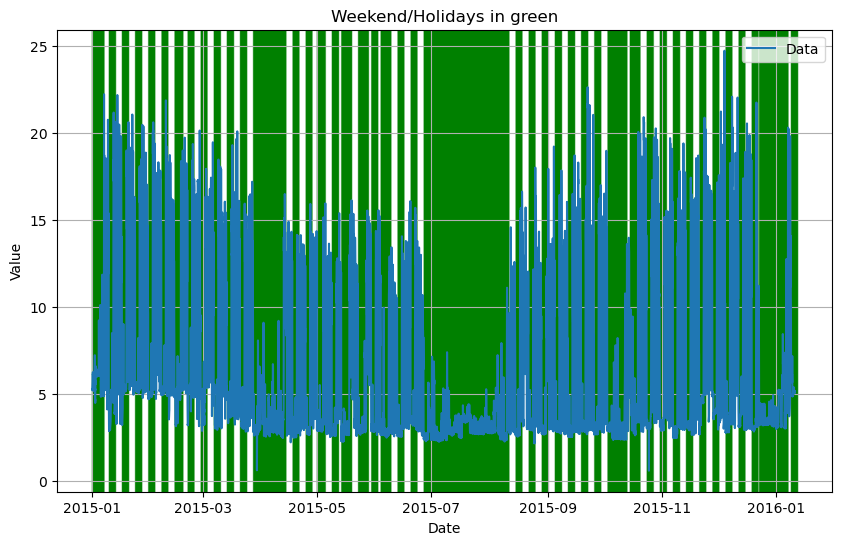

In [50]:
# Define the date range for plotting
start_date = '2015-01-01'
end_date = '2016-01-10'

# Filter data within the date range
data_to_plot = merged_result[start_date:end_date]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data_to_plot.index, data_to_plot['value_measured'], label='Data')

# Shade areas where prediction == 0 within the filtered date range
for date in data_to_plot.index[data_to_plot['prediction'] == '0']:
    plt.axvspan(date, date + pd.Timedelta(days=1), color='green', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Weekend/Holidays in green')
plt.legend(loc='upper right')
plt.grid(True)

# Ensure the plot displays
plt.show()